# Introduction to Decision Trees

In this notebook, we will apply a decision tree classifier to marketing data using the machine learning library `scikit-learn` in Python. 

We will first walk you quickly through the data processing using the `pandas` library. Feel free to read through and review it, but this is not important for today's session so don't worry if it looks unfamiliar (thoguh do feel free to ask questions!)

The important bits are the two "Hands on" sections, where you will fit the decisition tree classifier to the training data and evaluate it on the test data, and then where you will experiment with the model parameters.

## Guided walkthrough - data processing

We first import the packages that we will use during the practical:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### The dataset

The dataset is available in the `data/` directory, but it can be also downloaded from [here](https://archive.ics.uci.edu/ml/datasets/bank+marketing). It consists of data from marketing campaigns of a Portuguese bank. We will try to build a classifier that can predict whether or not the client targeted by the campaign ended up subscribing to a term deposit (column `y`).

We will first load the file `data/bank-marketing.csv` as a `pandas` DataFrame `df` and check the distribution of the target `y`.

In [2]:
df = pd.read_csv("data/bank-marketing.csv",sep=";")
df['y'].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


The dataset is imbalanced, so we will need to keep that in mind when building our models!

Now we split the data into the feature matrix `X` (all features except `y`) and the target vector `y`, making sure that you convert `yes` to `1` and `no` to `0`.

In [4]:
# Get X, y
y = df["y"].map({"no":0, "yes":1})
X = df.drop("y", axis=1)

Here is the list of features in our `X` matrix:

| | | |
| --- | --- | --- |
age | | numeric 
job | type of job | categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown'
marital | marital status | categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed
education | | categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown'
default | has credit in default? | categorical: 'no','yes','unknown'
housing | has housing loan? | categorical: 'no','yes','unknown'
loan | has personal loan? | categorical: 'no','yes','unknown'
contact | contact communication type | categorical: 'cellular','telephone'
month | last contact month of year | categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec'
day_of_week | last contact day of the week | categorical: 'mon','tue','wed','thu','fri'
duration | last contact duration, in seconds | numeric. Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
campaign | number of contacts performed during this campaign and for this client | numeric, includes last contact
pdays | number of days that passed by after the client was last contacted from a previous campaign | numeric; 999 means client was not previously contacted
previous | number of contacts performed before this campaign and for this client | numeric
poutcome | outcome of the previous marketing campaign | categorical: 'failure','nonexistent','success'
emp.var.rate | employment variation rate - quarterly indicator | numeric
cons.price.idx | consumer price index - monthly indicator | numeric
cons.conf.idx | consumer confidence index - monthly indicator | numeric
euribor3m | euribor 3 month rate - daily indicator | numeric 
nr.employed | number of employees - quarterly indicator | numeric

Note the comment about the `duration` feature. We will exclude it from our analysis.

In [8]:
X.drop("duration", inplace=True, axis=1)

Now we can check the types of all our features. We see that some seem to be categorical whilst others are numerical. We will keep two lists, one for each type, so we can preprocess them differently.

In [9]:
X.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
dtype: object

In [10]:
# when there is a third class "unknown", we'll process the feature as non-binary categorical
num_features = ["age", "campaign", "pdays", "previous", "emp.var.rate", 
                "cons.price.idx", "cons.conf.idx","euribor3m", "nr.employed"]

cat_features = ["job", "marital", "education","default", "housing", "loan",
                "contact", "month", "day_of_week", "poutcome"]

### One-hot encoding on categorical features

The `sklearn` implementation of decision trees cannot work directly with categorical features, so we need to make sure our dataset contains only numbers. Consequently, we will need to transform our categorical features into one-hot encoded features.

To do so, we use `pd.get_dummies` on our DataFrame (select only the categorical features - we already have them stored in the variable `cat_features`) to generate the new columns.

We assign the new DataFrame to a variable `X_categorical`.

In [12]:
X_categorical = pd.get_dummies(X[cat_features])
X_categorical.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
1,False,False,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
2,False,False,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
4,False,False,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False


Finally, we create a Dataframe with only our numerical features (we have their names stored in the variable `num_features`) from `X` together with the `X_categorical` DataFrame.

We use `pd.concat` (making sure to specify the correct axis!) and call the new DataFrame `X_processed`.

In [14]:
X_processed = pd.concat([X[num_features], X_categorical], axis=1)
X_processed.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,False,False,False,True,False,False,False,False,True,False
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,False,False,False,True,False,False,False,False,True,False
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,False,False,False,True,False,False,False,False,True,False
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,True,...,False,False,False,True,False,False,False,False,True,False
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,False,False,False,True,False,False,False,False,True,False


### Splitting the data into training and test sets

The last step is to split the data (use `X_processed`) into a training set and test set. Here we are dealing with an imbalanced dataset, so it is important to enforce stratification. We will use the argument `stratify` from `train_test_split` to do so.

We call the new variables `X_train`, `X_test`, `y_train`, and `y_test`.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed,
    y,
    test_size=.3,
    random_state=42,
    stratify=y
)

## Hands on Part 1 - Training a decision tree in scikit-learn

Now that we have done our preprocessing and our data is ready, we can get hands on and start doing some machine learning!

We will begin by training our first decision tree. We will use `DecisionTreeClassifier` from `sklearn.tree`.

For now we will keep our tree unconstrained with:
- `max_depth=None`
- `min_samples_split=2`

Create a new decision tree, assigning it to the variable `dtc`.

In [16]:
from sklearn.tree import DecisionTreeClassifier

# Your code here...

dtc = DecisionTreeClassifier(max_depth=None, min_samples_split=2)


Now fit the model on the training set:

In [17]:
# Your code here...
dtc.fit(X_train, y_train)


DecisionTreeClassifier()

Execute the cell below to display the tree in the notebook, what do you observe?

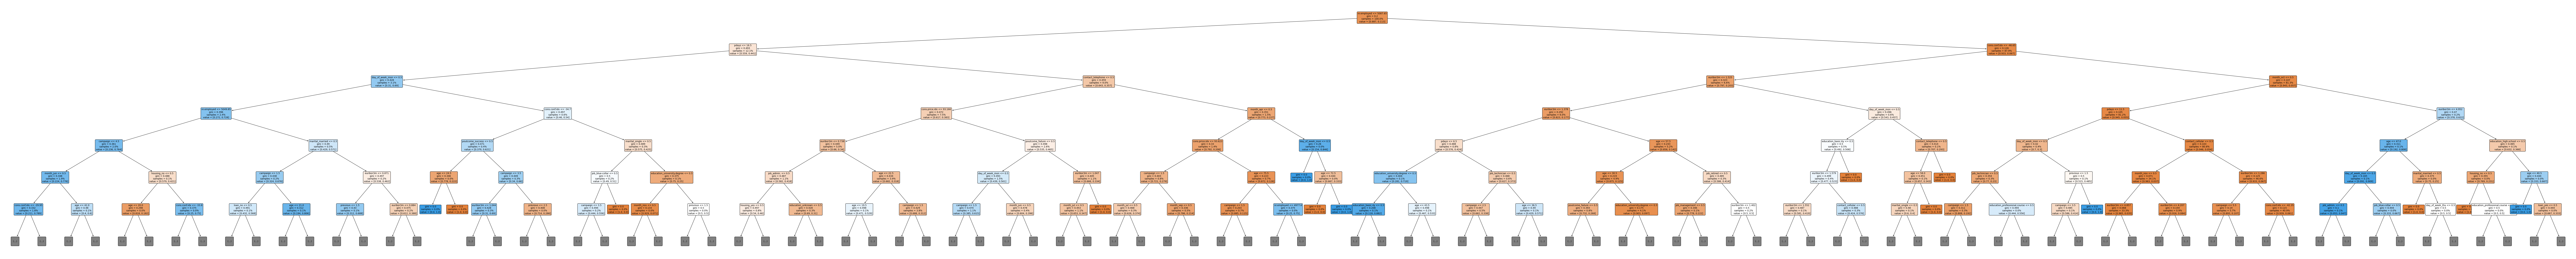

In [18]:
from sklearn import tree

plt.figure(figsize=(200, 20))
tree.plot_tree(dtc, 
               filled=True, 
               rounded=True,
               max_depth=6,
               proportion=True,
               fontsize=10,
               feature_names=X_train.columns)
plt.show()

Compute the accuracy of the model on the training data and then on the test data, what can you tell?

In [19]:
# Your code here...
from sklearn.metrics import accuracy_score

print(accuracy_score(y_train, dtc.predict(X_train)))
print(accuracy_score(y_test, dtc.predict(X_test)))


0.9961846623426173
0.8388767500202314


We can tell a lot more about what is going on with a deterministic (0-1) classifier by looking at the *confusion matrix*. 

It shows not only *how many* predictions our model gets right, but also *which* ground-truth classes the model is classifying correctly and incorrectly. 

Use the code below to display the confusion matrix of your model on the test data, and see if you can understand what it reveals about the model performance.

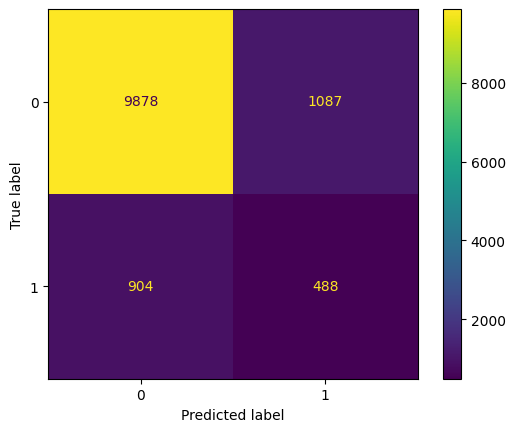

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(y_test, dtc.predict(X_test))).plot()

# Part 2: Decisition Tree parameters

## Parameter tuning

In order to prevent overfitting, we need to regularise (constrain) our model during model fitting. We can do this using the *model parameters*. 

To change the parameters of the existing tree classifier `dtc`, you can use `set_params` on it with the name and values you want to update (for example `max_depth=6`).

Try some different values for `max_depth`. You can also experiment with other parameters!

Don't forget to re-train the tree after changing the parameters.

In [41]:
# Your code here...
dtc.set_params(max_depth=5, min_samples_split=20)
dtc.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, min_samples_split=20)

Let's check the accuracy on both the train and the test set. Is it better than before?

In [42]:
# Your code here...
from sklearn.metrics import accuracy_score

print(accuracy_score(y_train, dtc.predict(X_train)))
print(accuracy_score(y_test, dtc.predict(X_test)))


0.9032638479414519
0.9013514607105284


Try experimenting with the parameters through trial and error to achieve the best accuracy on the test set. 

Don't worry about a grid-search or automating the search, the results aren't too important here!

Once you are happy with your paramters, you can visualise the resulting tree:

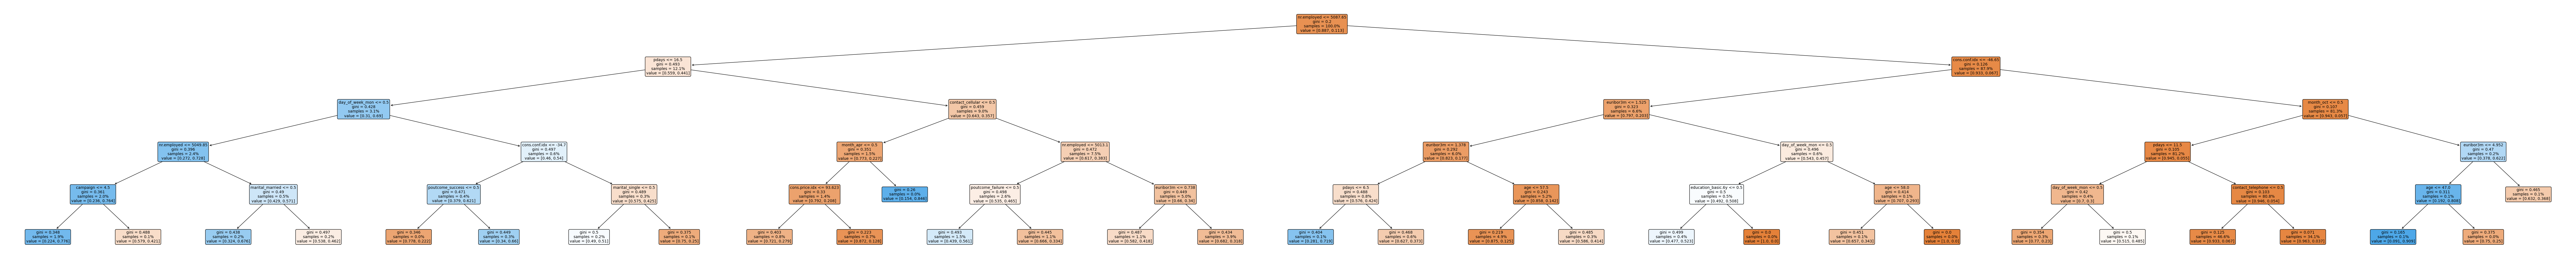

In [43]:
plt.figure(figsize=(120, 12))
tree.plot_tree(dtc, 
               filled=True, 
               rounded=True,
               max_depth=6,
               proportion=True,
               fontsize=10,
               feature_names=X_train.columns)
plt.show()

How does it compare to the one above?


Let's also have a look at the confusion matrix again:

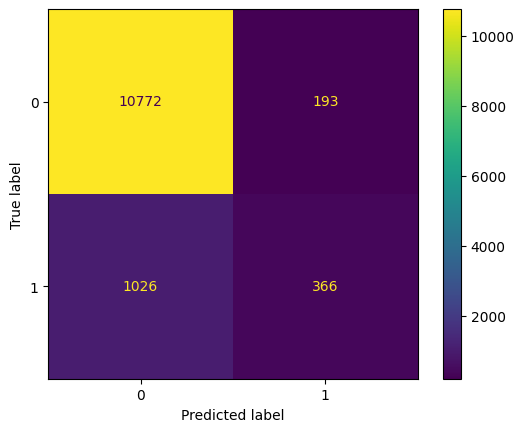

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(y_test, dtc.predict(X_test))).plot()

Our accuracy has improved, but what has happened to the confusion matrix? 

*Hint:* look closely at the number of predicted labels of class 1 vs the number of true labels of class 1.